# CoNet model
> Applying Co-occurrence Neural Networks for Recommendation on MovieLens dataset

- toc: true
- badges: true
- comments: true
- author: "<a href='https://github.com/XiuzeZhou/conet'>Xiuze Zhou</a>"
- categories: [Movie, Pytorch, AttentionMechanism]
- image:

### Introduction

CoNet stands for *Co-occurrence Neural Networks for Recommendation Chinese explanation*. At present, most recommendation algorithms assume that users-users and commodities-commodities are independent and identically distributed, so they only model the interaction between users-commodities, and ignore the relationship between commodities and commodities. CoNet assumes that commodities always appear in pairs, that is, commodities co-occur.

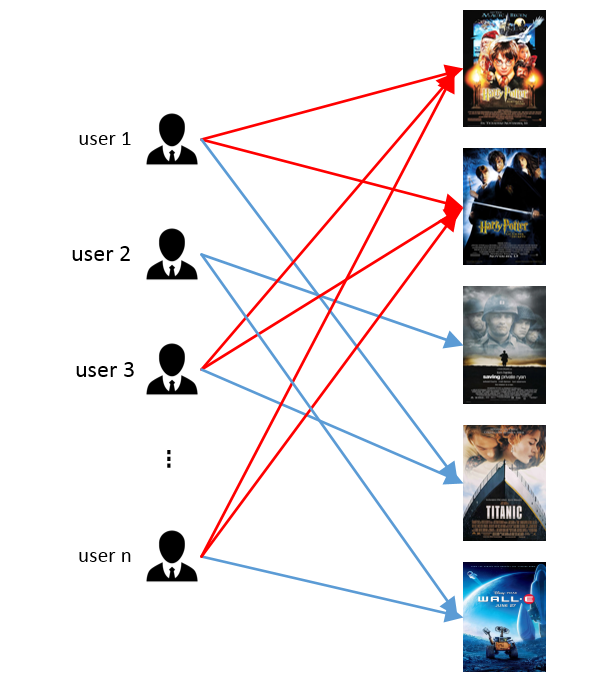

1. Give a small example, as shown in the figure above. For example, "Harry Potter 1" and "Harry Potter 2" are always watched by users who like magic at the same time. This is the co-occurrence model of commodities. In order to learn this model, we need to model the user-commodity and the product-commodity at the same time.

2. At the same time, CoNet assume that the more two commodities appear together, the more similar they are. For example, in the movie viewing record, "Harry Potter 1" and "Harry Potter 2" co-occur more than "Harry Potter 1" and "Robot Walle", we think that "Harry Potter 1" and "Harry Potter 2" are more similar.

3. Further, CoNet use the attention mechanism to learn the user's comparative preferences. When rated the two products separately, authors gave the same score. For example, when they watched "Harry Potter 1" and "Harry Potter 2", they found them to look good, and gave them 5 points. However, when compare the two of them, it always felt that one of them might be better. Therefore, authors used the attention mechanism to model and learn this psychological preference.

### Setup

In [1]:
import random
import math
import os
import numpy as np
import scipy.sparse as sp
import heapq # for retrieval topK
import multiprocessing
from time import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
def setup_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

### Dataset

In [3]:
!wget https://github.com/sparsh-ai/reco-data/raw/master/ml-conet.zip
!unzip ml-conet.zip

--2021-06-27 02:53:33--  https://github.com/sparsh-ai/reco-data/raw/master/ml-conet.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sparsh-ai/reco-data/master/ml-conet.zip [following]
--2021-06-27 02:53:34--  https://raw.githubusercontent.com/sparsh-ai/reco-data/master/ml-conet.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6901204 (6.6M) [application/zip]
Saving to: ‘ml-conet.zip’

ml-conet.zip        100%[===================>]   6.58M  --.-KB/s    in 0.1s    

2021-06-27 02:53:34 (46.0 MB/s) - ‘ml-conet.zip’ saved [6901204/6901204]

Archive:  ml-conet.zip
  inflating: 100k.test.negati

In [4]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2021-06-27 02:53:38--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  10.1MB/s    in 0.5s    

2021-06-27 02:53:39 (10.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [5]:
class Dataset(object):

    def __init__(self, path):
        '''
        Constructor
        '''
        self.trainMatrix = self.load_rating_file_as_matrix(path + ".train.rating")
        self.testRatings = self.load_rating_file_as_list(path + ".test.rating")
        self.testNegatives = self.load_negative_file(path + ".test.negative")
        assert len(self.testRatings) == len(self.testNegatives)
        
        self.num_users, self.num_items = self.trainMatrix.shape
        
    def load_rating_file_as_list(self, filename):
        ratingList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item = int(arr[0]), int(arr[1])
                ratingList.append([user, item])
                line = f.readline()
        return ratingList
    
    def load_negative_file(self, filename):
        negativeList = []
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                negatives = []
                for x in arr[1: ]:
                    negatives.append(int(x))
                negativeList.append(negatives)
                line = f.readline()
        return negativeList
    
    def load_rating_file_as_matrix(self, filename):
        '''
        Read .rating file and Return dok matrix.
        The first line of .rating file is: num_users\t num_items
        '''
        # Get number of users and items
        num_users, num_items = 0, 0
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                u, i = int(arr[0]), int(arr[1])
                num_users = max(num_users, u)
                num_items = max(num_items, i)
                line = f.readline()
        # Construct matrix
        mat = sp.dok_matrix((num_users+1, num_items+1), dtype=np.float32)
        with open(filename, "r") as f:
            line = f.readline()
            while line != None and line != "":
                arr = line.split("\t")
                user, item, rating = int(arr[0]), int(arr[1]), float(arr[2])
                if (rating > 0):
                    mat[user, item] = 1.0
                line = f.readline()    
        return mat

In [6]:
def generate_instances(train_mat, positive_size=2, negative_time=8, is_sparse=False):
    data = []
    users_num,items_num = train_mat.shape
    
    if is_sparse:
        indptr = train_mat.indptr
        indices = train_mat.indices
    for u in range(users_num):
        if is_sparse:
            rated_items = indices[indptr[u]:indptr[u+1]] #用户u中有评分项的id
        else:
            rated_items = np.where(train_mat[u,:]>0)[0]
        
        for item0 in rated_items:
            for item1 in np.random.choice(rated_items, size=positive_size):
                data.append([u,item0,item1,1.])
            for _ in range(positive_size*negative_time):
                item1 = np.random.randint(items_num) # no matter item1 is positive or negtive
                item2 = np.random.randint(items_num)
                while item2 in rated_items:
                    item2 = np.random.randint(items_num)
                data.append([u,item2,item1,0.])
    return data

### Architecture

CoNet consists of 7 parts: input layer, embedding layer, attention module, co-occurrence layer, interaction layer, hidden layer and prediction layer (output layer).

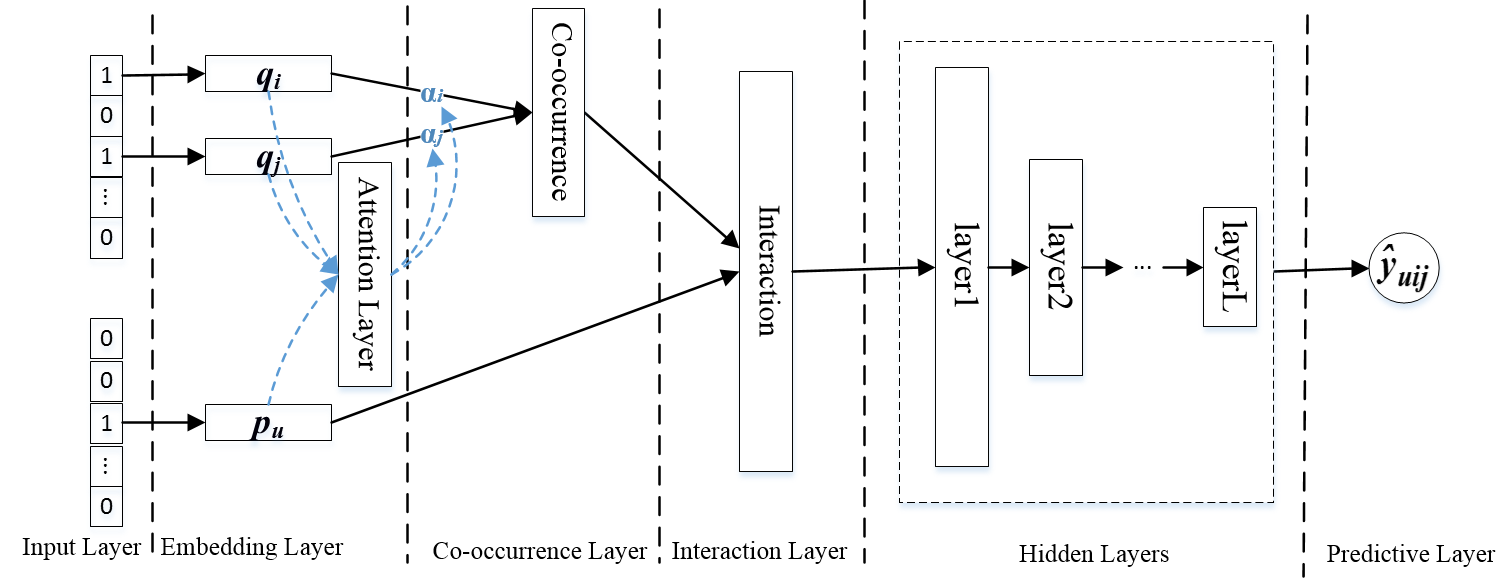

In [7]:
class CoNet(nn.Module):
    def __init__(self, users_num, items_num, embedding_size_users=64, embedding_size_items = 64, 
                 hidden_size = [64,32,16,8], is_attention = False):
        super(CoNet, self).__init__()
        self.embedding_size_users, self.embedding_size_items= embedding_size_users, embedding_size_items 
        self.items_num, self.users_num = items_num, users_num
        self.hidden_size, self.is_attention = hidden_size, is_attention
        self.embedding_user  = nn.Embedding(self.users_num, self.embedding_size_users)
        self.embedding_item = nn.Embedding(self.items_num, self.embedding_size_items)
        self.layer1 = nn.Linear(self.embedding_size_users + self.embedding_size_items, self.hidden_size[0])
        self.layers = [nn.Sequential(nn.Linear(self.hidden_size[i], self.hidden_size[i+1]), nn.ReLU()) for i in range(len(self.hidden_size) - 1)]
        self.linear = nn.Linear(self.hidden_size[-1], 1)
 
    def forward(self, x):
        embed_users = self.embedding_user(x[:,0])
        embed_items0 = self.embedding_item(x[:,1])
        embed_items1 = self.embedding_item(x[:,2])
        
        embed_items = (embed_items0 + embed_items1)/2.
        if self.is_attention:
            score0 = torch.reshape(torch.sum(embed_users * embed_items0, 1), shape=[-1,1])
            score1 = torch.reshape(torch.sum(embed_users * embed_items1, 1), shape=[-1,1])
            alpha = torch.sigmoid(score0 - score1)
            embed_items = alpha * embed_items0 + (1. - alpha) * embed_items1
            
        out = torch.cat([embed_users, embed_items],1)
        out = self.layer1(out)
        for layer in self.layers:
            out = layer(out)
        out = self.linear(out) 
        return out
    
    def predict(self, pairs, batch_size, verbose):
        """Computes predictions for a given set of user-item pairs.
        Args:
          pairs: A pair of lists (users, items) of the same length.
          batch_size: unused.
          verbose: unused.
        Returns:
          predictions: A list of the same length as users and items, such that
          predictions[i] is the models prediction for (users[i], items[i]).
        """
        del batch_size, verbose
        num_examples = len(pairs[0])
        assert num_examples == len(pairs[1])
        predictions = np.empty(num_examples)
        pairs = np.array(pairs, dtype=np.int16)
        for i in range(num_examples):
            x = np.c_[pairs[0][i],pairs[1][i],pairs[1][i]]
            x = torch.from_numpy(x).long()
            out = self.forward(x)
            predictions[i] = out.reshape(-1).data.numpy()
        return predictions
    
    def get_embeddings(self):
        idx = torch.LongTensor([i for i in range(self.items_num)])
        embeddings = self.embedding_item(idx)
        return embeddings

### Evaluation method

In [8]:
# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs = [],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        return (hits, ndcgs)
    # Single thread
    for idx in range(len(_testRatings)):
        (hr,ndcg) = eval_one_rating(idx)
        hits.append(hr)
        ndcgs.append(ndcg)      
    return (hits, ndcgs)

def eval_one_rating(idx):
    rating = _testRatings[idx]
    items = _testNegatives[idx]
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    # Get prediction scores
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    predictions = _model.predict([users, np.array(items)], 
                                 batch_size=100, verbose=0)
    for i in range(len(items)):
        item = items[i]
        map_item_score[item] = predictions[i]
    items.pop()
    
    # Evaluate top rank list
    ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [9]:
def evaluate(model, test_ratings, test_negatives, K=10):
    """Helper that calls evaluate from the NCF libraries."""
    (hits, ndcgs) = evaluate_model(model, test_ratings, test_negatives, K=K, num_thread=1)
    return np.array(hits).mean(), np.array(ndcgs).mean()

In [10]:
def get_similar_items(item_mat, idx, topk=5):
    m,k = item_mat.shape
    target_item = item_mat[idx,:]
    target_mat = np.reshape(np.tile(target_item,m),(-1,k))
    sim = [np.dot(target_mat[i], item_mat[i])/(np.linalg.norm(target_mat[i])*np.linalg.norm(item_mat[i])) 
           for i in range(m)] 
    sorted_items = np.argsort(-np.array(sim))
    return sorted_items[:topk+1] # the most similar is itself

def get_key(item_dict, value):
    key = -1
    for (k, v) in item_dict.items():
        if v == value:
            key = k
    return key


# read original records
def get_item_dict(file_dir):
    # output: 
    # N: the number of user;
    # M: the number of item
    # data: the list of rating information
    user_ids_dict, rated_item_ids_dict = {},{}
    N, M, u_idx, i_idx = 0,0,0,0 
    data_rating = []
    data_time = []
    f = open(file_dir)
    for line in f.readlines():
        if '::' in line:
            u, i, r = line.split('::')[:3]
        elif ',' in line:
            u, i, r = line.split(',')[:3]
        else:
            u, i, r = line.split()[:3]
    
        if u not in user_ids_dict:
            user_ids_dict[u]=u_idx
            u_idx+=1
        if i not in rated_item_ids_dict:
            rated_item_ids_dict[i]=i_idx
            i_idx+=1
        data_rating.append([user_ids_dict[u],rated_item_ids_dict[i],float(r)])
    
    f.close()
    N = u_idx
    M = i_idx

    return rated_item_ids_dict

# read id and its name
def id_name(file_dir):
    id_name_dict = {}
    f = open(file_dir, 'r', encoding='latin-1')
    for line in f.readlines():
        movie_id, movie_name = line.split('|')[:2]
        id_name_dict[int(movie_id)] = movie_name
        
    return id_name_dict

### Model training

In [11]:
def train(model, train_mat, test_ratings, test_negatives, users_num, items_num, train_list=None, test_list=None,
          learning_rate = 1e-2, weight_decay=0.01, positive_size=1, negative_time=4, epochs=64, 
          batch_size=1024, topK=10, mode='hr'):
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    if train_list!=None:
        train_mat= sequence2mat(sequence=train_list, N=users_num, M=items_num) # train data : user-item matrix
        is_sparse = False
    
    hr_list=[]
    ndcg_list=[]
    hr, ndcg = evaluate(model, test_ratings, test_negatives, K=topK)
    embeddings = model.get_embeddings()
    hr_list.append(hr)
    ndcg_list.append(ndcg)
    print('Init: HR = %.4f, NDCG = %.4f' %(hr, ndcg))
    best_hr, best_ndcg = hr, ndcg
    for epoch in range(epochs):
        data_sequence = generate_instances(train_mat, positive_size=positive_size, negative_time=negative_time, is_sparse=True)
        #data_sequence = read_list("output/" + str(epoch) + ".txt")
        
        train_size = len(data_sequence)
        np.random.shuffle(data_sequence)
        batch_size = batch_size
        total_batch = math.ceil(train_size/batch_size)

        for batch in range(total_batch):
            start = (batch*batch_size)% train_size
            end = min(start + batch_size, train_size)
            data_array = np.array(data_sequence[start:end])
            x = torch.from_numpy(data_array[:,:3]).long()
            y = torch.from_numpy(data_array[:,-1]).reshape(-1,1)
            y_ = model(x)
            loss = criterion(y_.float(), y.float())
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients
            
        # Evaluation
        hr, ndcg = evaluate(model, test_ratings, test_negatives, K=topK)
        hr_list.append(hr)
        ndcg_list.append(ndcg)
        print('epoch=%d, loss=%.4f, HR=%.4f, NDCG=%.4f' %(epoch, loss, hr, ndcg))
        
        mlist = hr_list
        if mode == 'ndcg':
            mlist = ndcg_list
        if (len(mlist) > 20) and (mlist[-2] < mlist[-3] > mlist[-1]):
            best_hr, best_ndcg = hr_list[-3], ndcg_list[-3]
            embeddings = model.get_embeddings()
            break
        best_hr, best_ndcg = hr, ndcg
        embeddings = model.get_embeddings()
            
    print("End. Best HR = %.4f, NDCG = %.4f. " %(best_hr, best_ndcg))
    return embeddings

In [15]:
dataset_path = '/content/100k'

# Load the dataset
dataset = Dataset(dataset_path)
train_mat, test_ratings, test_negatives = dataset.trainMatrix, dataset.testRatings, dataset.testNegatives
print('Dataset: #user=%d, #item=%d, #train_pairs=%d, #test_pairs=%d' 
      % (dataset.num_users, dataset.num_items, train_mat.nnz, len(test_ratings)))

embedding_size_users = 64
embedding_size_items = 64
hidden_size = [64,32,16]
is_attention = True
learning_rate = 1e-3
weight_decay = 1e-5

positive_size = 2
negative_time = 8
epochs = 10
batch_size = 1024
topK = 10
mode = 'hr'
seed = 18

setup_seed(seed)
# Initialize the model
model = CoNet(users_num=dataset.num_users, items_num=dataset.num_items, embedding_size_users=embedding_size_users, 
              embedding_size_items=embedding_size_items, hidden_size=hidden_size, is_attention=is_attention)

if torch.cuda.is_available():
    model = model.cuda()

# Train and evaluate model
embeddings = train(model=model, 
                  train_mat=train_mat.tocsr(), 
                  test_ratings=test_ratings, 
                  test_negatives=test_negatives, 
                  users_num=dataset.num_users, 
                  items_num=dataset.num_items,  
                  learning_rate=learning_rate,
                  weight_decay=weight_decay,
                  positive_size=positive_size,
                  negative_time=negative_time,
                  epochs=epochs,
                  batch_size=batch_size,
                  topK=topK,
                  mode=mode)
print('----------------------------------------------------------')

Dataset: #user=943, #item=1682, #train_pairs=99057, #test_pairs=943
Init: HR = 0.1039, NDCG = 0.0442
epoch=0, loss=0.0817, HR=0.4655, NDCG=0.2639
epoch=1, loss=0.0533, HR=0.4836, NDCG=0.2628
epoch=2, loss=0.0545, HR=0.5673, NDCG=0.3271
epoch=3, loss=0.0580, HR=0.6235, NDCG=0.3512
epoch=4, loss=0.0556, HR=0.6193, NDCG=0.3493
epoch=5, loss=0.0545, HR=0.6373, NDCG=0.3633
epoch=6, loss=0.0300, HR=0.6384, NDCG=0.3699
epoch=7, loss=0.0482, HR=0.6596, NDCG=0.3723
epoch=8, loss=0.0507, HR=0.6490, NDCG=0.3774
epoch=9, loss=0.0433, HR=0.6564, NDCG=0.3802
End. Best HR = 0.6564, NDCG = 0.3802. 
----------------------------------------------------------


### Experiment results

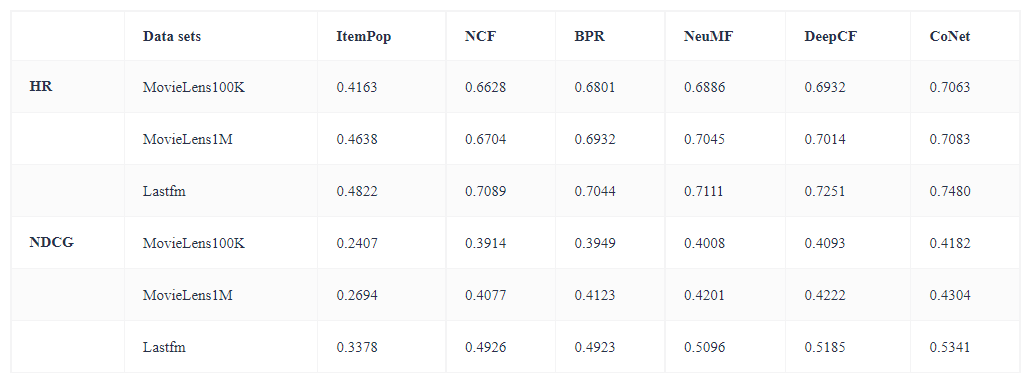

### Effect of attention

The red curve is the attention mechanism, and the blue is the result of not paying attention.

In fact, it can be understood that the attention mechanism provides more parameters to fit the user's comparative preferences to achieve better results.

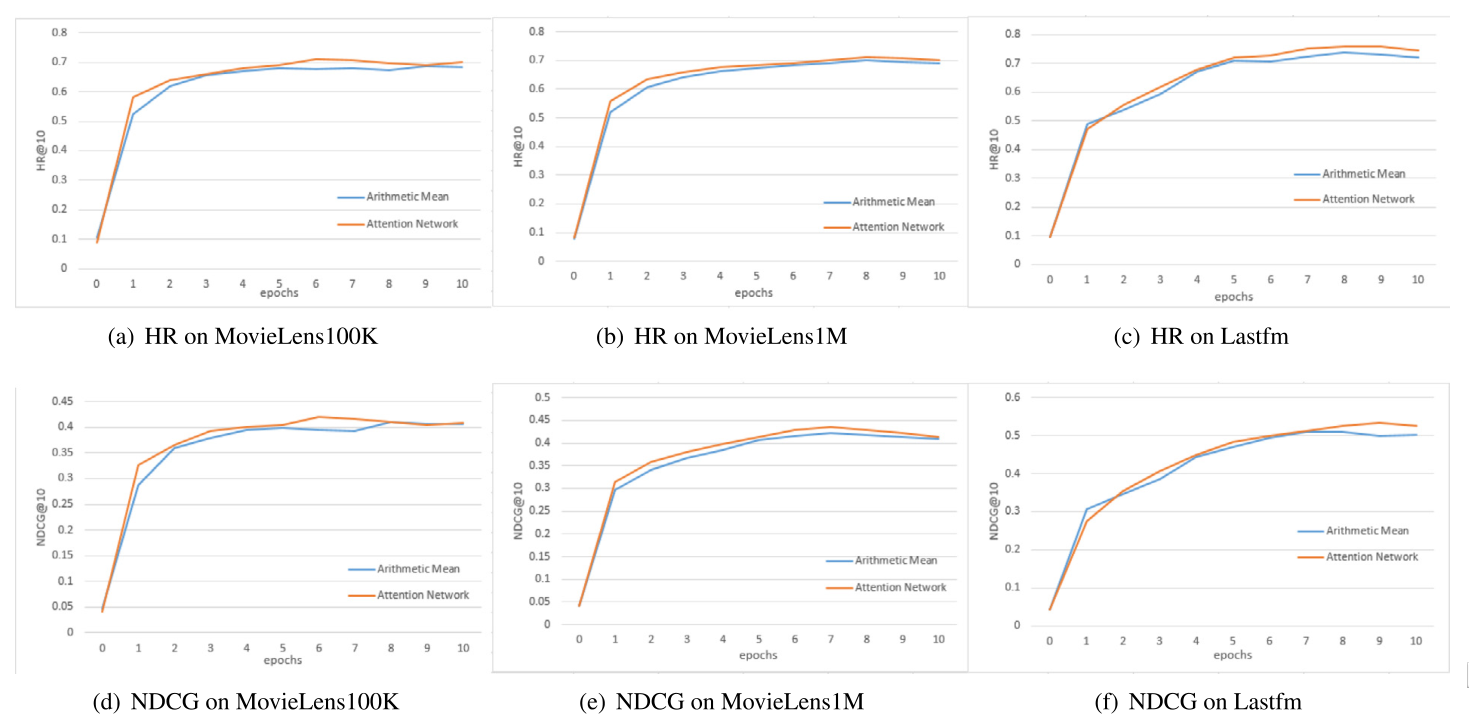

### Inference

In [16]:
file_dir = '/content/ml-100k/u.item'
id_name_dict = id_name(file_dir) # original id : movie name

file_dir = '/content/ml-100k/u.data'
item_dict = get_item_dict(file_dir) # original id : new id

In [18]:
movieid_list = [113, 347, 537]
    
for movieid in movieid_list:
    print('MovieID:', movieid, '; MovieName:', id_name_dict[movieid])
    original_id = str(movieid)
    target_item = item_dict[original_id]

    top5 = get_similar_items(embeddings.data.numpy(), idx=target_item)
    movie_list = [get_key(item_dict=item_dict, value=i) for i in top5]
    rec_list = [id_name_dict[int(movie_id)] for movie_id in movie_list[1:]]
    for i in range(len(rec_list)):
        print('\n{0}: {1}'.format(i+1, rec_list[i]))
    print('------------------------------------------------------------------')

MovieID: 113 ; MovieName: Horseman on the Roof, The (Hussard sur le toit, Le) (1995)

1: Cérémonie, La (1995)

2: Ed's Next Move (1996)

3: Flower of My Secret, The (Flor de mi secreto, La) (1995)

4: Margaret's Museum (1995)

5: Thieves (Voleurs, Les) (1996)
------------------------------------------------------------------
MovieID: 347 ; MovieName: Wag the Dog (1997)

1: Apt Pupil (1998)

2: Deconstructing Harry (1997)

3: Kolya (1996)

4: Jackal, The (1997)

5: Wings of the Dove, The (1997)
------------------------------------------------------------------
MovieID: 537 ; MovieName: My Own Private Idaho (1991)

1: Bronx Tale, A (1993)

2: Red Rock West (1992)

3: Paris, Texas (1984)

4: Carlito's Way (1993)

5: Some Folks Call It a Sling Blade (1993)
------------------------------------------------------------------
